In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.stats import skew, kurtosis
def filter_blood_vessels(image_path):
    # Load the image
    image = sitk.ReadImage(image_path, sitk.sitkFloat32)

    # Apply Gaussian smoothing
    smoothed = sitk.SmoothingRecursiveGaussian(image, sigma=2.0)#used 2

    # Use Canny edge detection
    edges = sitk.CannyEdgeDetection(smoothed, lowerThreshold=0.5, upperThreshold=3.0)# used 1

    # Thresholding to create a binary image
    binary = sitk.BinaryThreshold(edges, lowerThreshold=0.5, upperThreshold=1.0)

    # Convert SimpleITK image to NumPy array for visualization
    binary_array = sitk.GetArrayFromImage(binary)

    # Display results using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.title("Blood Vessel Segmentation")
    plt.imshow(binary_array, cmap='gray')
    plt.axis('off')
    plt.show()

 # Feature extraction
    extract_features(binary_array)

def extract_features(binary_image):
    # Flatten the binary image to calculate features
    flat_image = binary_image.flatten()

    # Calculate features
    mean_value = np.mean(flat_image)
    variance_value = np.var(flat_image)
    std_dev_value = np.std(flat_image)
    skewness_value = skew(flat_image)
    kurtosis_value = kurtosis(flat_image)

    # Calculate entropy
    histogram, _ = np.histogram(flat_image, bins=256, range=(0, 1))
    histogram = histogram / histogram.sum()  # Normalize
    entropy_value = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))  # Add small epsilon to avoid log(0)

    # Print the features
    print(f"Mean: {mean_value}")
    print(f"Variance: {variance_value}")
    print(f"Standard Deviation: {std_dev_value}")
    print(f"Skewness: {skewness_value}")
    print(f"Kurtosis: {kurtosis_value}")
    print(f"Entropy: {entropy_value}")
# Example usage
filter_blood_vessels('/home/gcekcse/Documents/ML_Project_hk/data/train_images/e582e56e7942.png')


ModuleNotFoundError: No module named 'SimpleITK'

Area of the largest contour: 22167.5 pixels


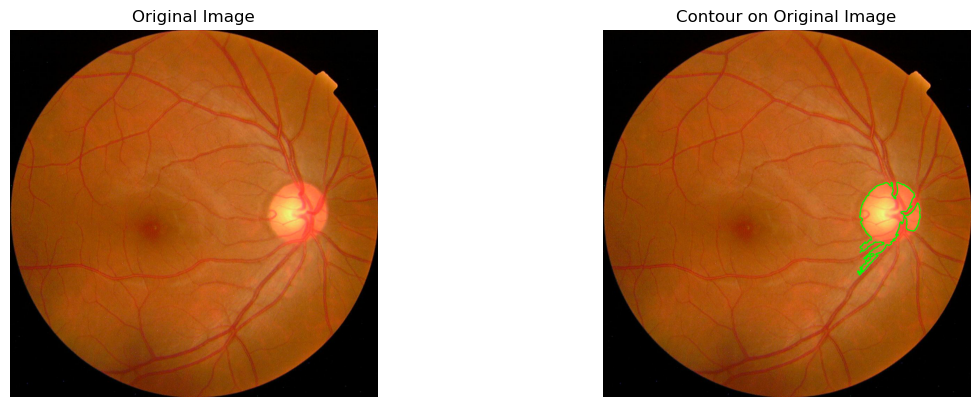

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/mnt/sda2/jijiya_files/project_2/jrpdata/test_images/e582e56e7942.png'  # Update with your image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or invalid image path")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur to reduce noise and improve contour detection
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold the image to create a binary mask for bright white areas
_, mask = cv2.threshold(blurred, 133, 255, cv2.THRESH_BINARY)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If contours are found, proceed to find the largest contour
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the area of the largest contour
    area = cv2.contourArea(largest_contour)
    print(f"Area of the largest contour: {area} pixels")
    
    # Draw the largest contour directly on the original image
    contour_image = image.copy()  # Create a copy of the original image
    cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)  # Draw in green

    # Isolate the bright areas in the original image using the mask
    segmented_bright_areas = cv2.bitwise_and(image, image, mask=mask)

    # Prepare images for display
    titles = ['Original Image', 'Contour on Original Image']
    images = [image, contour_image]

    # Display results using matplotlib
    plt.figure(figsize=(12, 8))
    for i in range(2):
        plt.subplot(2, 2, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No contours found")


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from scipy.stats import skew, kurtosis
import SimpleITK as sitk
# Function to segment the optic disc
def segment_optic_disc(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold the image to create a binary mask for bright areas
    _, mask = cv2.threshold(blurred, 133, 255, cv2.THRESH_BINARY)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # If contours are found, proceed to find the largest contour
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        print(f"Area of the largest contour: {area} pixels")

        # Draw the largest contour directly on the original image
        contour_image = image.copy()
        cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

        # Return the mask and contour image
        return mask, contour_image
    else:
        print("No contours found")
        return mask, image

# Function to segment blood vessels
def segment_blood_vessels(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian smoothing to reduce noise
    smoothed = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use adaptive thresholding to create a binary mask
    binary_mask = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological operations to enhance the blood vessels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    # Use Canny edge detection for further refinement
    edges = cv2.Canny(morphed, threshold1=30, threshold2=100)

    return binary_mask

# Load the image
image_path = '/mnt/sda2/jijiya_files/project_2/jrpdata/test_images/e582e56e7942.png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or invalid image path")

# Segment optic disc and blood vessels
optic_disc_mask, contour_image = segment_optic_disc(image)
blood_vessel_mask = segment_blood_vessels(image)

# Optional: Combine masks if needed
combined_mask = cv2.bitwise_or(optic_disc_mask, blood_vessel_mask)

# Display results
def visualize_results(image, optic_disc_mask, blood_vessel_mask, combined_mask, contour_image):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    #plt.subplot(2, 2, 2)
    #plt.imshow(optic_disc_mask, cmap='gray')
    #plt.title("Optic Disc Mask")
    #plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian smoothing to reduce noise
    smoothed = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use adaptive thresholding to create a binary mask
    binary_mask = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    # Morphological operations to enhance the blood vessels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    # Use Canny edge detection for further refinement
    edges = cv2.Canny(morphed, threshold1=30, threshold2=100)



2024-10-25 08:48:05.764016: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 08:48:05.913244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 08:48:05.996583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 08:48:06.021997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-25 08:48:06.129141: I tensorflow/core/platform/cpu_feature_guar

Area of the largest contour: 22167.5 pixels


Area of the largest contour: 22167.5 pixels


/tmp/ipykernel_3385352/869593481.py:69: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
2024-10-25 08:48:09.873443: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CNN Features Shape: (1, 1280)


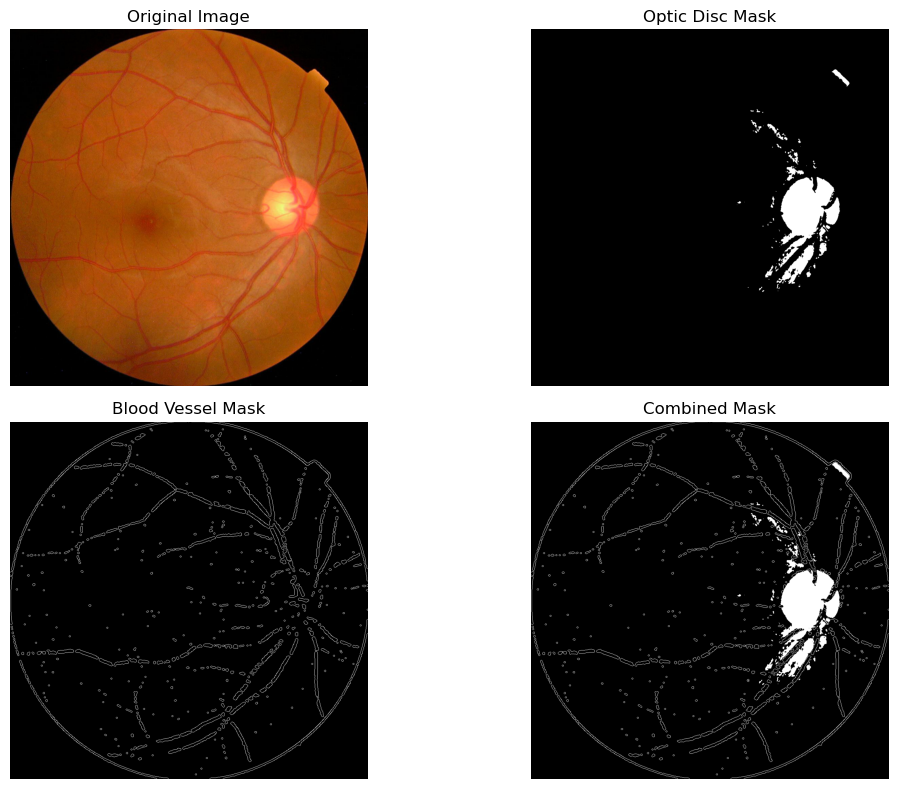

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from scipy.stats import skew, kurtosis

# Function to segment the optic disc
def segment_optic_disc(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 133, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        print(f"Area of the largest contour: {area} pixels")

        contour_image = image.copy()
        cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

        return mask, contour_image
    else:
        print("No contours found")
        return mask, image

# Function to segment blood vessels
def segment_blood_vessels(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smoothed = cv2.GaussianBlur(gray, (5, 5), 0)

    binary_mask = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    edges = cv2.Canny(morphed, threshold1=30, threshold2=100)

    return edges

# Load the image
image_path = '/mnt/sda2/jijiya_files/project_2/jrpdata/test_images/e582e56e7942.png'
image = cv2.imread(image_path)
if image is None:
    raise ValueError("Image not found or invalid image path")

# Segment optic disc and blood vessels
optic_disc_mask, contour_image = segment_optic_disc(image)
blood_vessel_mask = segment_blood_vessels(image)

# Combine masks if needed
combined_mask = cv2.bitwise_or(optic_disc_mask, blood_vessel_mask)

def prepare_data_for_cnn(image):
    # Resize image to the input size required by the CNN
    image_resized = cv2.resize(image, (224, 224))
    # Normalize and preprocess for MobileNetV2
    image_preprocessed = preprocess_input(image_resized)
    return np.expand_dims(image_preprocessed, axis=0)  # Add batch dimension

# Prepare inputs for the CNN
cnn_input = prepare_data_for_cnn(image)

# Load the MobileNetV2 model
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Extract features using the CNN
cnn_features = model.predict(cnn_input)
print(f"CNN Features Shape: {cnn_features.shape}")
# Display results
def visualize_results(image, optic_disc_mask, blood_vessel_mask, combined_mask, contour_image):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(optic_disc_mask, cmap='gray')
    plt.title("Optic Disc Mask")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(blood_vessel_mask, cmap='gray')
    plt.title("Blood Vessel Mask")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(combined_mask, cmap='gray')
    plt.title("Combined Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(image, optic_disc_mask, blood_vessel_mask, combined_mask, contour_image)


2024-11-05 16:19:35.124522: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 16:19:35.251977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 16:19:35.319077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 16:19:35.338478: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 16:19:35.426683: I tensorflow/core/platform/cpu_feature_guar

Model Training started.....
 epoch 1 batch 10 completed
 epoch 1 batch 20 completed
 epoch 1 batch 30 completed
 epoch 1 batch 40 completed
 epoch 1 batch 50 completed
 epoch 1 batch 60 completed
 epoch 1 batch 70 completed
 epoch 1 batch 80 completed
 epoch 1 batch 90 completed
 epoch 1 batch 100 completed
 epoch 1 batch 110 completed
 epoch 1 batch 120 completed
Epoch: 1/50.. Training Loss: 1.136.. Valid Loss: 0.759.. Valid Accuracy: 0.724
 epoch 2 batch 10 completed
 epoch 2 batch 20 completed
 epoch 2 batch 30 completed
 epoch 2 batch 40 completed
 epoch 2 batch 50 completed
 epoch 2 batch 60 completed
 epoch 2 batch 70 completed
 epoch 2 batch 80 completed
 epoch 2 batch 90 completed
 epoch 2 batch 100 completed
 epoch 2 batch 110 completed
 epoch 2 batch 120 completed
Epoch: 2/50.. Training Loss: 0.584.. Valid Loss: 0.518.. Valid Accuracy: 0.801
 epoch 3 batch 10 completed
 epoch 3 batch 20 completed
 epoch 3 batch 30 completed
 epoch 3 batch 40 completed
 epoch 3 batch 50 comple

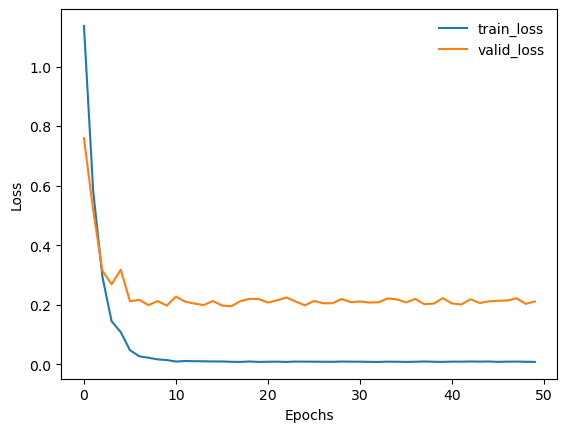

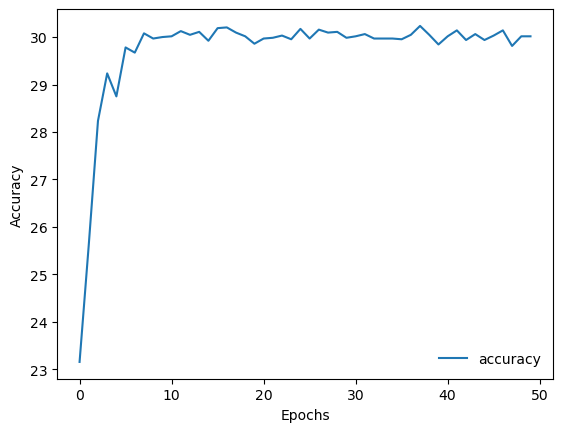

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from scipy.stats import skew, kurtosis
from __future__ import print_function, division
from torch.utils import data
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import seaborn as sns
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
# Function to segment the optic disc
def segment_optic_disc(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 133, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        #print(f"Area of the largest contour: {area} pixels")

        contour_image = image.copy()
        cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 2)

        return mask, contour_image
    else:
        #print("No contours found")
        return mask, image

# Function to segment blood vessels
def segment_blood_vessels(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    smoothed = cv2.GaussianBlur(gray, (5, 5), 0)

    binary_mask = cv2.adaptiveThreshold(smoothed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    morphed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    edges = cv2.Canny(morphed, threshold1=30, threshold2=100)

    return edges

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir, transform=None, mask_transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        self.mask_transform = mask_transform  # Separate transform for masks

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.png')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Ensure image is RGB

        # Segment the optic disc and blood vessels
        optic_disc_mask, _ = segment_optic_disc(image)
        blood_vessel_mask = segment_blood_vessels(image)

        # Combine masks
        combined_mask = cv2.bitwise_or(optic_disc_mask, blood_vessel_mask)

        # Apply transforms
        if self.transform is not None:
            image = self.transform(image)
        if self.mask_transform is not None:
            combined_mask = self.mask_transform(combined_mask)

        return image, label


# Image transforms
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Mask transforms (if masks are single-channel)
mask_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load dataset and paths
train_csv = pd.read_csv('/mnt/sda2/jijiya_files/project_2/jrpdata/train.csv')
test_csv = pd.read_csv('/mnt/sda2/jijiya_files/project_2/jrpdata/test.csv')
base_dir = "/mnt/sda2/jijiya_files/project_2/jrpdata"
train_path = base_dir + "/train_images/"
test_path = base_dir + "/test_images/"
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
for i, x in enumerate(class_list):
    counts[x] = counts.pop(i)
# Dataset loading
train_data = CreateDataset(df_data=train_csv, data_dir=train_path, 
                           transform=train_transforms, mask_transform=mask_transforms)
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, 
                          transform=test_transforms, mask_transform=mask_transforms)


# Data loaders
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=64)

model = models.resnet152(pretrained=True)
num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, out_ftrs),
    nn.LogSoftmax(dim=1)
)

# Loss, optimizer, scheduler
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Freezing layers
for name, child in model.named_children():
    if name in ['layer2', 'layer3', 'layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False
# Train and test loop
def train_and_test(e):
    epochs = e
    train_losses, test_losses, acc = [], [], []
    valid_loss_min = np.Inf
    model.train()
    print("Model Training started.....")
    
    for epoch in range(epochs):
        running_loss = 0
        batch = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch += 1
            if batch % 10 == 0:
                print(f" epoch {epoch + 1} batch {batch} completed")
        
        test_loss, accuracy = 0, 0
        with torch.no_grad():
            model.eval()
            for images, labels in validloader:
                images, labels = images.to(device), labels.to(device)
                logps = model(images)
                test_loss += criterion(logps, labels)
                ps = torch.exp(logps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(validloader))
        acc.append(accuracy)
        scheduler.step()
        
        print(f"Epoch: {epoch + 1}/{epochs}.. "
              f"Training Loss: {running_loss/len(trainloader):.3f}.. "
              f"Valid Loss: {test_loss/len(validloader):.3f}.. "
              f"Valid Accuracy: {accuracy/len(validloader):.3f}")
        
        if test_loss / len(validloader) <= valid_loss_min:
            torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       "/mnt/sda2/jijiya_files/project_2/jrpdata/models/classifier.pt")
            valid_loss_min = test_loss / len(validloader)
    print('Training Completed Succesfully !')
    return train_losses, test_losses, acc

train_losses, valid_losses, acc = train_and_test(50)
# Plotting training curves
plt.plot(train_losses, label='train_loss')
plt.plot([x.cpu().numpy() for x in valid_losses], label='valid_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

plt.plot([x.cpu().numpy() for x in acc], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()




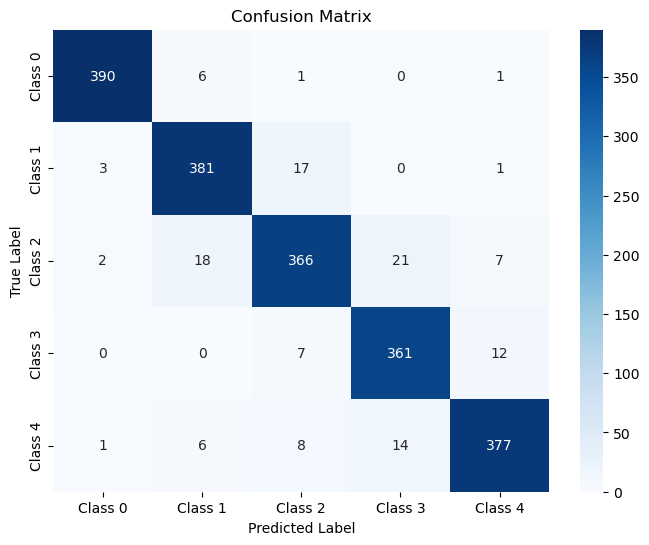

In [2]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset


class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Assuming you have a model defined and trained
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move the model to the device

# If you have class names
class_list = [f'Class {i}' for i in range(len(class_list))]  # Replace with your actual class names

def generate_confusion_matrix(model, validloader, class_list, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)  # Convert log probabilities to probabilities
            top_p, top_class = ps.topk(1, dim=1)  # Get top predicted class
            
            y_true.extend(labels.cpu().numpy())  # Append true labels
            y_pred.extend(top_class.cpu().numpy())  # Append predicted labels

    # Flatten the y_pred list if needed
    y_pred = [x[0] for x in y_pred]  # Extract class index

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming you have a model, dataloader, class_list, and device defined
generate_confusion_matrix(model, validloader, class_list, device)



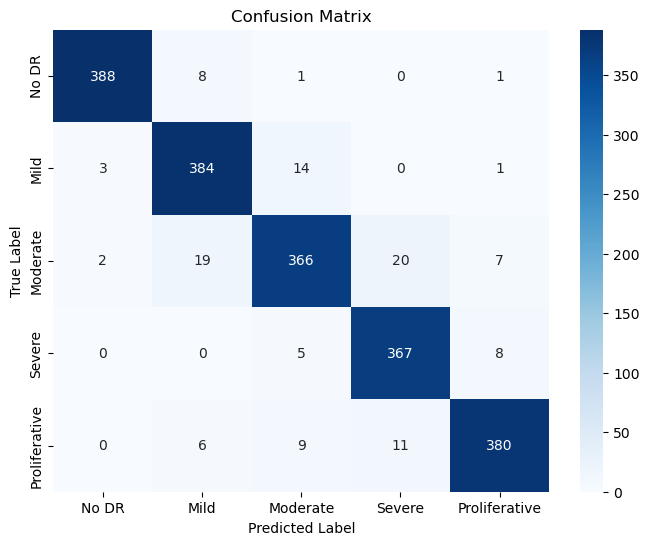

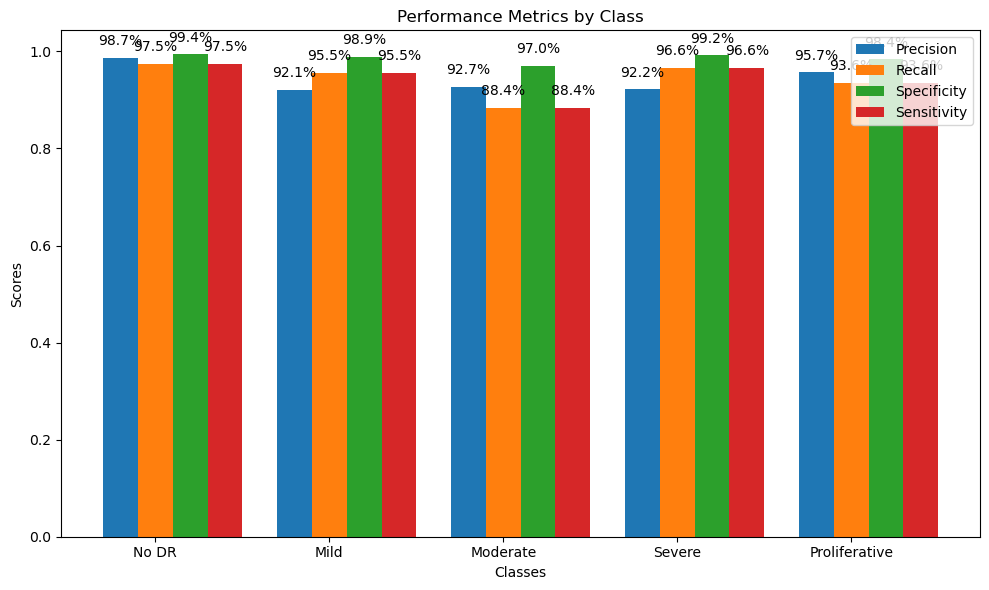

In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import numpy as np

class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Assuming you have a model defined and trained
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move the model to the device

def generate_confusion_matrix(model, validloader, class_list, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)  # Convert log probabilities to probabilities
            top_p, top_class = ps.topk(1, dim=1)  # Get top predicted class
            
            y_true.extend(labels.cpu().numpy())  # Append true labels
            y_pred.extend(top_class.cpu().numpy())  # Append predicted labels

    # Flatten the y_pred list if needed
    y_pred = [x[0] for x in y_pred]  # Extract class index

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    specificity = []
    for i in range(len(class_list)):
        tn = sum(cm[j][k] for j in range(len(class_list)) for k in range(len(class_list)) if j != i and k != i)
        specificity.append(tn / (tn + cm[i].sum() - cm[i][i]))

    sensitivity = recall  # Sensitivity is equivalent to recall

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plotting Precision, Recall, Specificity, and Sensitivity
    metrics = [precision, recall, specificity, sensitivity]
    metric_names = ['Precision', 'Recall', 'Specificity', 'Sensitivity']

    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(class_list))

    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        bars = plt.bar(index + i * bar_width, metric, bar_width, label=name)

        # Add percentage text above each bar
        for bar in bars:
            height = bar.get_height()
            # Display the percentage above each bar
            plt.text(
                bar.get_x() + bar.get_width() / 2, 
                height + 0.02,  # Slightly above the bar
                f'{height * 100:.1f}%',  # Percentage format
                ha='center', va='bottom', fontsize=10
            )

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Class')
    plt.xticks(index + bar_width, class_list)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming you have a model, dataloader, class_list, and device defined
generate_confusion_matrix(model, validloader, class_list, device)


Using device: cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


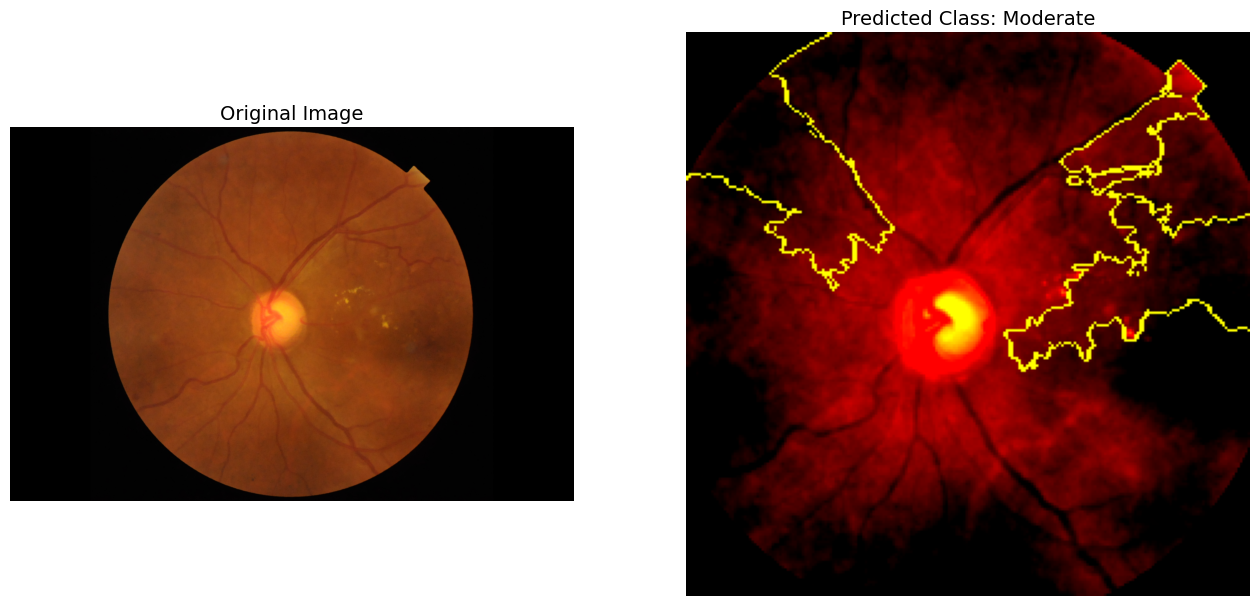

In [7]:
# Assuming model is already loaded
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model.to(device)  # Move the model to the device

# Define the prediction function for LIME
def predict_fn(images):
    # Convert images to PyTorch tensor and move to device
    images = torch.tensor(images).permute(0, 3, 1, 2).to(device)  # Convert from HWC to CHW
    images = images.float()  # Convert to float for model input
    with torch.no_grad():
        output = model(images)
    return torch.nn.functional.softmax(output, dim=1).cpu().numpy()  # Move output to CPU and return probabilities

# Create the LIME explainer and explain the prediction
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(
    img_tensor[0].numpy().transpose(1, 2, 0),  # Convert to HWC format
    predict_fn,  # Use the custom predict_fn
    top_labels=5, 
    hide_color=0,
    num_samples=1000
)

# Get the image and label to visualize
output = model(img_tensor.to(device))  # Forward pass through the model
predicted_class = output.argmax(dim=1)  # Get the predicted class index
predicted_class_label = class_list[predicted_class.item()]  # Map index to custom class label

# Get the explanation mask and image
temp, mask = explanation.get_image_and_mask(
    predicted_class.item(),
    positive_only=True,
    hide_rest=False
)

# Plotting the original image and the LIME explanation side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the original image on the left
axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis('off')

# Plot the image with LIME mask on the right
axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title(f"Predicted Class: {predicted_class_label}", fontsize=14)
axes[1].axis('off')

plt.show()



Using device: cpu


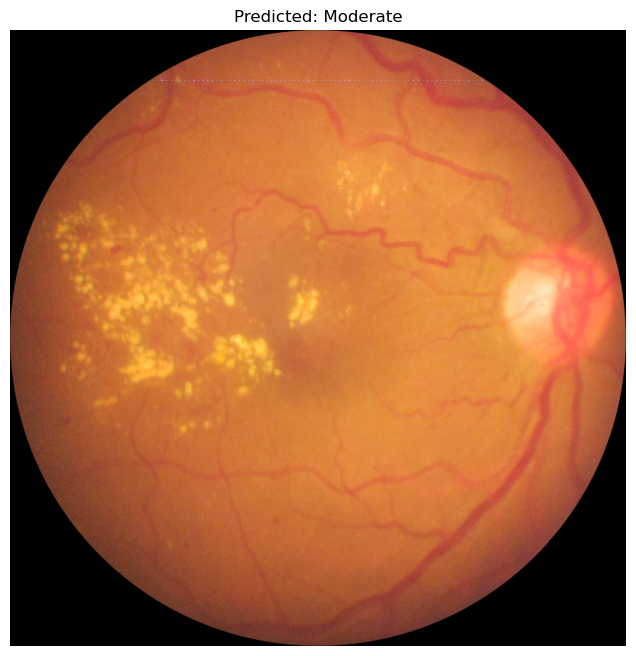

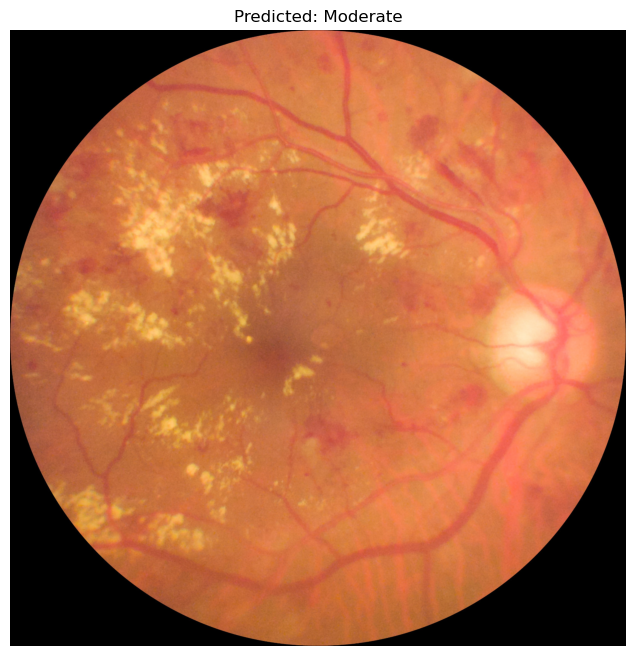

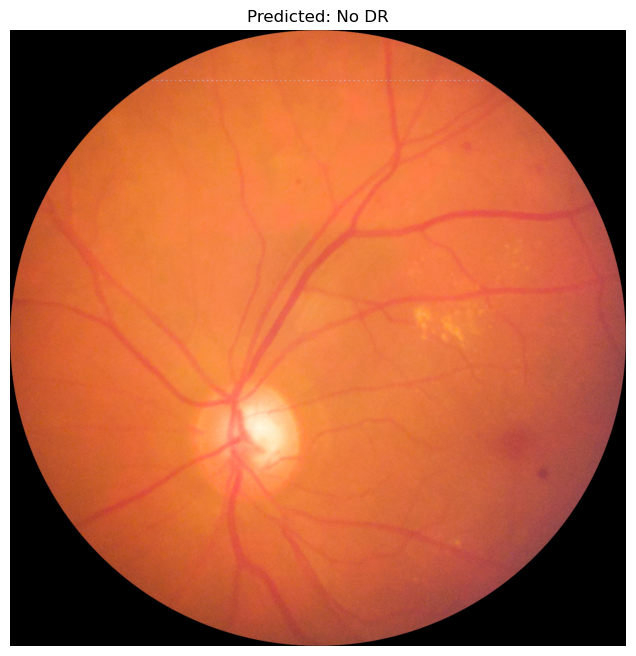

In [8]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Check if CUDA is available and set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming model is already loaded and set to evaluation mode
model.to(device)
model.eval()

# Load the class labels (You need to set this according to your model's output)
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']  # Example; replace with actual class labels

# Define image transformations (same as the ones used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to model input size (224x224 for most models)
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Function to load and predict a single image
def predict_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Open image and ensure it's RGB
    img_tensor = transform(img).unsqueeze(0).to(device)  # Apply transforms and add batch dimension

    # Perform forward pass through the model
    with torch.no_grad():
        output = model(img_tensor)
    
    # Get predicted class index
    predicted_class = output.argmax(dim=1).item()  # Get index of max probability
    predicted_class_label = class_list[predicted_class]
    
    return img, predicted_class_label

# Folder containing test images (you should replace this with your folder path)
image_folder = '/home/gcekcse/Documents/ML_Project_hk/data/my_images/'  # Example: './test_images/'

# Read all image files in the directory
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'png', 'jpeg'))]

# Loop through the images and display them with predicted labels
for image_file in image_files:
    img, predicted_label = predict_image(image_file)
    
    # Plot image and predicted label
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


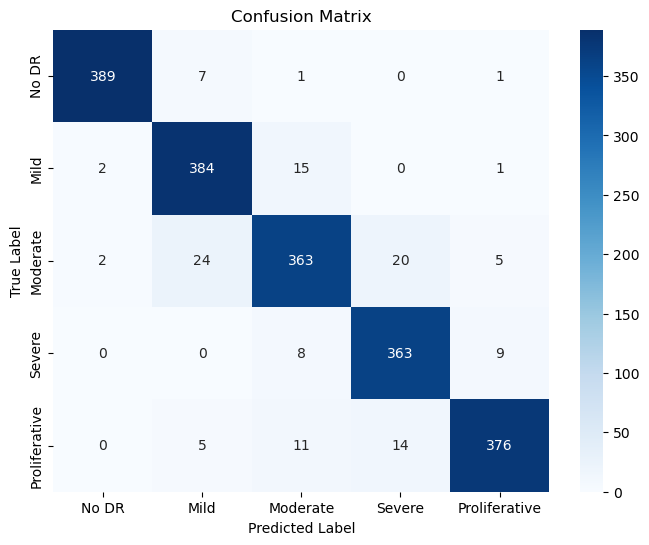

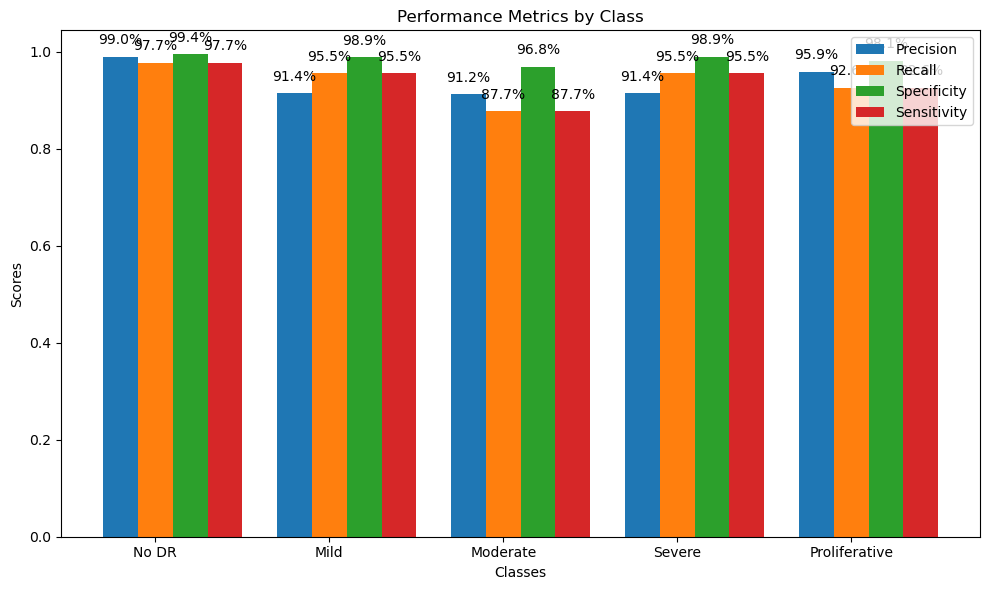

In [5]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import numpy as np

class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']

# Assuming you have a model defined and trained
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move the model to the device

def generate_confusion_matrix(model, validloader, class_list, device):
    y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            logps = model(images)
            ps = torch.exp(logps)  # Convert log probabilities to probabilities
            top_p, top_class = ps.topk(1, dim=1)  # Get top predicted class
            
            y_true.extend(labels.cpu().numpy())  # Append true labels
            y_pred.extend(top_class.cpu().numpy())  # Append predicted labels

    # Flatten the y_pred list if needed
    y_pred = [x[0] for x in y_pred]  # Extract class index

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    specificity = []
    for i in range(len(class_list)):
        tn = sum(cm[j][k] for j in range(len(class_list)) for k in range(len(class_list)) if j != i and k != i)
        specificity.append(tn / (tn + cm[i].sum() - cm[i][i]))

    sensitivity = recall  # Sensitivity is equivalent to recall

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_list, yticklabels=class_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Plotting Precision, Recall, Specificity, and Sensitivity
    metrics = [precision, recall, specificity, sensitivity]
    metric_names = ['Precision', 'Recall', 'Specificity', 'Sensitivity']

    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(class_list))

    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        bars = plt.bar(index + i * bar_width, metric, bar_width, label=name)

        # Add percentage text above each bar
        for bar in bars:
            height = bar.get_height()
            # Display the percentage above each bar
            plt.text(
                bar.get_x() + bar.get_width() / 2, 
                height + 0.02,  # Slightly above the bar
                f'{height * 100:.1f}%',  # Percentage format
                ha='center', va='bottom', fontsize=10
            )

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Performance Metrics by Class')
    plt.xticks(index + bar_width, class_list)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming you have a model, dataloader, class_list, and device defined
generate_confusion_matrix(model, validloader, class_list, device)


In [2]:
#!pip install torch torchvision matplotlib

Using device: cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

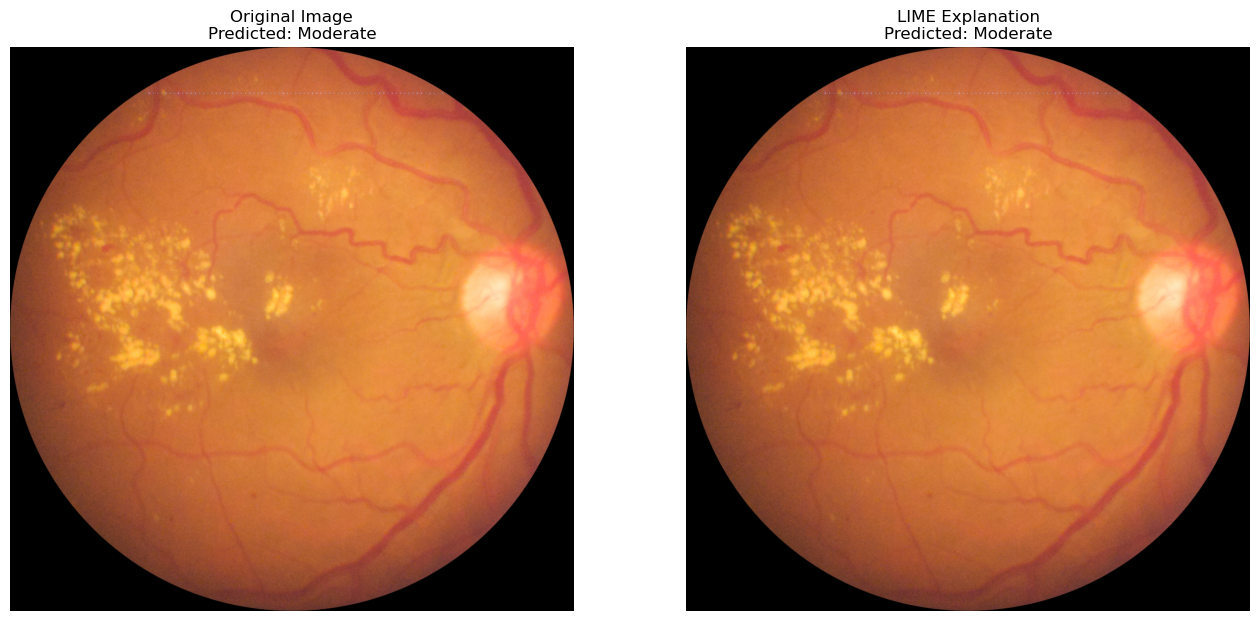

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Check if CUDA is available and set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Assuming model is already loaded and set to evaluation mode
model.to(device)
model.eval()

# Load the class labels (You need to set this according to your model's output)
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']  # Example; replace with actual class labels

# Define image transformations (same as the ones used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to model input size (224x224 for most models)
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Function to load and predict a single image
def predict_fn(images):
    images = torch.tensor(images).permute(0, 3, 1, 2).to(device)  # Convert from HWC to CHW
    images = images.float()  # Convert to float for model input
    with torch.no_grad():
        output = model(images)
    return torch.nn.functional.softmax(output, dim=1).cpu().numpy()  # Move output to CPU and return probabilities

# Function to load an image, predict its label, and get the explanation
def predict_image_with_lime(image_path):
    # Open the image and apply necessary transformations
    img = Image.open(image_path).convert('RGB')  # Open image and ensure it's RGB
    img_array = np.array(img)  # Convert image to numpy array for LIME

    # Perform the prediction using the model
    img_tensor = transform(img).unsqueeze(0).to(device)  # Apply transforms and add batch dimension
    with torch.no_grad():
        output = model(img_tensor)
    predicted_class = output.argmax(dim=1).item()  # Get index of max probability
    predicted_class_label = class_list[predicted_class]

    # Use LIME for explanation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array,               # The image to explain
        predict_fn,              # The prediction function
        top_labels=5,            # Get top 5 predicted labels (you can change this)
        hide_color=0,            # Hide background color
        num_samples=1000         # Number of samples for LIME to generate (can be reduced for speed)
    )

    # Get the explanation mask and image with the superimposed mask
    temp, mask = explanation.get_image_and_mask(
        predicted_class,         # The class for which to get the explanation
        positive_only=True,      # Show positive contribution (relevant pixels)
        hide_rest=False          # Show other regions as well
    )

    return img, predicted_class_label, temp, mask

# Folder containing test images (you should replace this with your folder path)
image_folder = '/home/gcekcse/Documents/ML_Project_hk/data/my_images/' # Example: './test_images/'

# Read all image files in the directory
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('jpg', 'png', 'jpeg'))]

# Loop through the images and display them with predicted labels and LIME explanation
for image_file in image_files:
    # Get the image, prediction, and LIME explanation
    img, predicted_label, temp, mask = predict_image_with_lime(image_file)
    
    # Plot the original image and the LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the original image on the left
    axes[0].imshow(img)
    axes[0].set_title(f"Original Image\nPredicted: {predicted_label}")
    axes[0].axis('off')

    # Plot the image with LIME mask on the right
    axes[1].imshow(mark_boundaries(temp, mask))
    axes[1].set_title(f"LIME Explanation\nPredicted: {predicted_label}")
    axes[1].axis('off')

    plt.show()
